In [1]:
import numpy as np
import pandas as pd
import sys,os
import random
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from run_desmond import run_DESMOND<
from utils.eval import find_best_matches, generate_exprs

# Simulated expression data 

* 10000 genes x 200 samples
* background ~N(0,1), bicluster ~ N(4,1)
* four biclusters with fraction [0.05,0.1,0.25,0.5] of all samples simulate four subtypes
* three scenarios A,B,C
    * for each scenario, bicluster sizes in genes were 5,50,500 
    * 3 scenarios x 3 gene sizes = 9 expression matrices in total

### scenario A:
 * biclusters are not overlapping in genes and samples
 * all other genes are independent  ~N(0,1)

### scenario B:
 * biclusters are overlapping in genes and samples
 * all other genes are independent  ~N(0,1)

### scenario C:
 * overlapping in genes and samples
 * four co-expressed modules of 500 genes each
 

# In this example, scenario C with 500-gene biclusters is shown

co-exprs. module  500 r= 0.5163183482003796
co-exprs. module  500 r= 0.550515632064485
co-exprs. module  500 r= 0.4673190541856959
co-exprs. module  500 r= 0.5219359202997877
expressions: data/simulated//C.n_genes=5,m=4,std=1,overlap=yes.exprs_z.tsv
true bilusters: data/simulated//C.n_genes=5,m=4,std=1,overlap=yes.biclusters.tsv
co-exprs. module  500 r= 0.5878110534411453
co-exprs. module  500 r= 0.48921514647194275
co-exprs. module  500 r= 0.5829052665422135
co-exprs. module  500 r= 0.5655942436136903
expressions: data/simulated//C.n_genes=50,m=4,std=1,overlap=yes.exprs_z.tsv
true bilusters: data/simulated//C.n_genes=50,m=4,std=1,overlap=yes.biclusters.tsv
co-exprs. module  500 r= 0.5906572670724503
co-exprs. module  500 r= 0.47852039437200444
co-exprs. module  500 r= 0.5033343612754967
co-exprs. module  500 r= 0.4881485433177523
expressions: data/simulated//C.n_genes=500,m=4,std=1,overlap=yes.exprs_z.tsv
true bilusters: data/simulated//C.n_genes=500,m=4,std=1,overlap=yes.biclusters.t

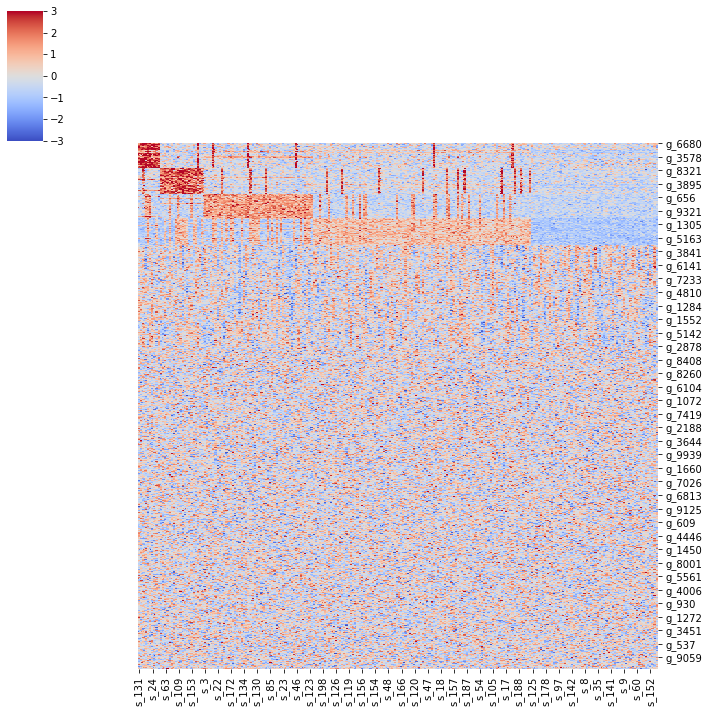

In [6]:
# background expressions N(0,1)
seed = 42
n_genes = 10000
N = 200


# genes,percent_of_samples
frac_samples = [0.05,0.1,0.25,0.5] #10,20,50,100

outdir = "data/simulated/"
outfile_basename="C"

m = 4
std = 1


for gene_size in [5,50,500]:
    exprs, ground_truth,coexpressed_modules = generate_exprs((n_genes,N),g_size=gene_size,frac_samples=[0.05,0.1,0.25,0.5],m=m,std=std,
                           outdir = outdir,outfile_basename=outfile_basename, 
                           g_overlap=True,s_overlap=True,
                           seed = seed, add_coexpressed = [500]*4)#add_coexpressed = [500]*4





bic_g = []
bic_s = []
for row in ground_truth.iterrows():
    bic = row[1]
    g = list(bic["genes"])
    s = list(bic["samples"])
    bic_g += g
    bic_s += s
    
for module in coexpressed_modules:
    bic_g +=  module
    
bg_g = set(exprs.index.values).difference(set(bic_g))
bg_s = set(exprs.columns.values).difference(set(bic_s))

samples = bic_s + list(bg_s)
genes = bic_g + list(bg_g)
cg = sns.clustermap(exprs.loc[genes,samples],row_cluster=False,col_cluster=False,
                    cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3)
cg.ax_row_dendrogram.set_visible(False)

# Evaluation

In [2]:
# expression file
exprs_file = "data/simulated/C/C.n_genes=500,m=4,std=1,overlap=yes.exprs_z.tsv"

# read ground truth from file
ground_truth_file = "data/simulated/C/C.n_genes=500,m=4,std=1,overlap=yes.biclusters.tsv"
ground_truth = pd.read_csv(ground_truth_file,sep ="\t",index_col=0)
ground_truth["samples"] = ground_truth["samples"].apply(lambda x: set(x.split(" ")))
if "genes" in ground_truth.columns.values:
    ground_truth["genes"] = ground_truth["genes"].apply(lambda x: set(x.split(" ")))

ground_truth

,genes,samples,frac,n_genes,n_samples:,n_samples
0.05,"{g_6073, g_2033, g_789, g_8997, g_2708, g_3005...","{s_194, s_55, s_46, s_197, s_144, s_75, s_185,...",0.05,500,10,10
0.10,"{g_7261, g_3346, g_859, g_8744, g_2015, g_8692...","{s_159, s_88, s_109, s_51, s_194, s_21, s_94, ...",0.10,500,20,20
0.25,"{g_3786, g_9725, g_234, g_1407, g_8644, g_3231...","{s_29, s_36, s_13, s_185, s_50, s_88, s_34, s_...",0.25,500,50,50
0.50,"{g_4925, g_5176, g_7834, g_333, g_2443, g_4971...","{s_102, s_185, s_17, s_115, s_138, s_136, s_20...",0.50,500,100,100


In [3]:
# prepare a dict with sample groups corresponding to known bicluster
known_groups = {}
for group in ground_truth.index.values:
    known_groups[group] = ground_truth.loc[group,"samples"]

In [5]:
# run method - e.g. DESMOND
min_n_samples = 5
pval =0.001
r = 1/3
bin_method = "Jenks"
clust_method = "Louvain"
cluster_binary=False
out_dir = os.getcwd()+"/tmp_results/"
basename = "simulated" 

result = run_DESMOND(exprs_file, basename, out_dir="tmp_results/",  
                binarized_data = None, save=True, load = False,
                bin_method = bin_method, 
                clust_method = clust_method, cluster_binary=cluster_binary, 
                min_n_samples = min_n_samples, show_fits = [],
                pval = pval,
                r = r,
                seed = -1,
                verbose = True, plot_all = False)

seed= 679205
Read input from: data/simulated/C/C.n_genes=500,m=4,std=1,overlap=yes.exprs_z.tsv
	10000 features x 200 samples
Mininal number of samples in a bicluster: 5

Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 200,
		number of samples in a bicluster: 5 - 100,
		n_permutations: 10001
snr_pval threshold: 0.001


Input is standardized.
min_n_samples is recommended to be >= 10


			fraction: 0.1
	SNR thresholds for individual features computed in 0.71 seconds
	Jenks method is chosen ...
		genes processed: 0
		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
	Jenks binarization for 10000 features completed in 3.33 s
	binarization runtime: 4.04 s
	1032 features passed binarization 
		UP-regulated features:	1003
		DOWN-regulated features:	94
		ambiguous features:	65
Statistics is saved to tmp_results//simulated.Jenks.binarization_stats.tsv
Binarized gene expressions are saved to tmp_results//simulated.Jenks.binarized_UP.tsv
Binarized gene expressions are saved to tmp_results//simulated.Jenks.binarized_DOWN.tsv
	 modules: 3 not_clustered: 18
		modularity: 0.51 runtime: 0.07 s
	 modules: 4 not_clustered: 21
		modularity: 0.027 runtime: 0.01 s
tmp_results/simulated.bin=Jenks,clust=Louvain.biclusters.tsv


### Method output
* must be a dataFrame with (bi-)cluster index and "samples" coulum
* "samples" column contrain sets of samples

In [6]:
# DESMOND result
result

,gene_indexes,n_genes,sample_indexes,n_samples,avgSNR,direction,genes,samples
0,"[8523, 1028, 241, 6159, 1829, 7035, 3842, 8652...",75,"{19, 21, 149, 151, 153, 159, 32, 40, 45, 175, ...",20,1.945744,UP,"{g_8523, g_1028, g_241, g_6159, g_1829, g_7035...","{s_159, s_88, s_51, s_109, s_194, s_21, s_94, ..."
1,"[8253, 7271, 4270, 1893, 5898, 6952, 1197, 714...",45,"{0, 2, 4, 6, 10, 11, 13, 17, 18, 19, 20, 25, 3...",100,1.73571,UP,"{g_8253, g_7271, g_4270, g_1893, g_5898, g_695...","{s_102, s_185, s_17, s_115, s_138, s_136, s_20..."
2,"[8605, 6646, 7080, 6889, 9738, 6184, 3984, 725...",12,"{1, 3, 5, 7, 8, 9, 12, 14, 15, 16, 21, 22, 23,...",92,1.672513,DOWN,"{g_8605, g_6646, g_7080, g_6889, g_9738, g_618...","{s_44, s_8, s_178, s_97, s_21, s_42, s_69, s_1..."
3,"[3786, 9725, 234, 1407, 8644, 3231, 1798, 2176...",452,"{0, 130, 3, 132, 5, 134, 7, 13, 20, 148, 22, 2...",50,1.644735,UP,"{g_3786, g_9725, g_234, g_1407, g_8644, g_3231...","{s_29, s_36, s_13, s_185, s_50, s_88, s_34, s_..."
4,"[4925, 5176, 7834, 333, 2443, 4971, 1074, 3847...",458,"{0, 2, 4, 6, 10, 11, 13, 17, 18, 19, 20, 25, 3...",100,1.642081,UP,"{g_4925, g_5176, g_7834, g_333, g_2443, g_4971...","{s_102, s_185, s_17, s_115, s_138, s_136, s_20..."
5,"[3088, 5163, 3838, 8013, 9029, 7030, 4173, 888...",11,"{1, 131, 133, 8, 9, 137, 139, 12, 140, 14, 15,...",71,1.597743,DOWN,"{g_3088, g_5163, g_3838, g_8013, g_9029, g_703...","{s_44, s_15, s_33, s_8, s_78, s_139, s_141, s_..."
6,"[2499, 2853, 1245, 254, 3292]",5,"{1, 3, 5, 7, 8, 9, 12, 14, 15, 16, 22, 23, 24,...",91,1.561374,DOWN,"{g_2499, g_2853, g_1245, g_254, g_3292}","{s_44, s_8, s_178, s_97, s_42, s_69, s_155, s_..."


# Finding best matches for each known sample cluster
* J - Jaccard similarity of known sample group and its best match
* J_weighted - Jaccard index proporional to bicluster size in terms of samples
* J total = sum(J_weighted) - betweem 0 and 1

In [7]:
N = 200  # total numner of samples in expression file
best_matches = find_best_matches(result,known_groups,N,FDR=0.05)
print("Total weighted J:",best_matches["J_weighted"].sum())
best_matches

Total weighted J: 0.9713450292397661


,group_size,J,is_enriched,best_match_id,gene_indexes,n_genes,sample_indexes,n_samples,avgSNR,direction,genes,samples,J_weighted
known_group,,,,,,,,,,,,,
0.05,10,0.484211,False,2,"[8605, 6646, 7080, 6889, 9738, 6184, 3984, 725...",12,"{1, 3, 5, 7, 8, 9, 12, 14, 15, 16, 21, 22, 23,...",92,1.672513,DOWN,"{g_8605, g_6646, g_7080, g_6889, g_9738, g_618...","{s_44, s_8, s_178, s_97, s_21, s_42, s_69, s_1...",0.026901
0.10,20,1.0,True,0,"[8523, 1028, 241, 6159, 1829, 7035, 3842, 8652...",75,"{19, 21, 149, 151, 153, 159, 32, 40, 45, 175, ...",20,1.945744,UP,"{g_8523, g_1028, g_241, g_6159, g_1829, g_7035...","{s_159, s_88, s_51, s_109, s_194, s_21, s_94, ...",0.111111
0.25,50,1.0,True,3,"[3786, 9725, 234, 1407, 8644, 3231, 1798, 2176...",452,"{0, 130, 3, 132, 5, 134, 7, 13, 20, 148, 22, 2...",50,1.644735,UP,"{g_3786, g_9725, g_234, g_1407, g_8644, g_3231...","{s_29, s_36, s_13, s_185, s_50, s_88, s_34, s_...",0.277778
0.50,100,1.0,True,1,"[8253, 7271, 4270, 1893, 5898, 6952, 1197, 714...",45,"{0, 2, 4, 6, 10, 11, 13, 17, 18, 19, 20, 25, 3...",100,1.73571,UP,"{g_8253, g_7271, g_4270, g_1893, g_5898, g_695...","{s_102, s_185, s_17, s_115, s_138, s_136, s_20...",0.555556


### another example - K-means
* performance is limited

In [11]:
from sklearn.cluster import KMeans

exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)

model = KMeans(n_clusters=5)
labels = model.fit_predict(exprs.T)


result2 = {}
sample_names = exprs.columns.values
for clust in set(labels):
    s = set(sample_names[labels == clust])
    result2[clust] = {"samples":s,"n_samples":len(s)}
result2 = pd.DataFrame.from_dict(result2).T
result2

,samples,n_samples
0,"{s_88, s_159, s_51, s_109, s_194, s_21, s_94, ...",20
1,"{s_183, s_135, s_154, s_102, s_17, s_150, s_6,...",70
2,"{s_36, s_13, s_185, s_115, s_179, s_148, s_120...",19
3,"{s_29, s_50, s_34, s_23, s_43, s_168, s_192, s...",28
4,"{s_44, s_15, s_33, s_8, s_78, s_60, s_139, s_1...",63


In [12]:
best_matches2 = find_best_matches(result2,known_groups,200,FDR=0.05)
print("Total weighted J:",best_matches2["J_weighted"].sum())
best_matches2

Total weighted J: 0.6555555555555557


,group_size,J,is_enriched,best_match_id,samples,n_samples,J_weighted
known_group,,,,,,,
0.05,10.0,0.0,NaN,NaN,NaN,NaN,0.0
0.10,20,1.0,True,0,"{s_88, s_159, s_51, s_109, s_194, s_21, s_94, ...",20,0.111111
0.25,50,0.56,True,3,"{s_29, s_50, s_34, s_23, s_43, s_168, s_192, s...",28,0.155556
0.50,100,0.7,True,1,"{s_183, s_135, s_154, s_102, s_17, s_150, s_6,...",70,0.388889
